In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
 # Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [25]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [26]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [27]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [28]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

# Precipitation Analysis

- Design a query to retrieve the last 12 months of precipitation data.
- Select only the date and prcp values.
- Load the query results into a Pandas DataFrame and set the index to the date column.
- Sort the DataFrame values by date.
- Plot the results using the DataFrame plot method.

In [42]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

last_date = session.query(Measurement.date,Measurement.prcp).order_by(Measurement.date.desc()).first()[0]
last_year = dt.datetime.strptime(last_date,"%Y-%m-%d")- dt.timedelta(days=365)
last_year = str(last_year.date())

# Perform a query to retrieve the data and precipitation scores

prcp_query = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >=last_year, Measurement.date <=last_date).\
order_by(Measurement.date).statement

prcp_df = pd.read_sql(prcp_query, engine).dropna()
prcp_df.rename(columns={"date":"Date","prcp":"Precipitation"},inplace=True)
prcp_df["Date"] = pd.to_datetime(prcp_df["Date"])
prcp_df.head(5)



,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
4,2016-08-23,0.02
5,2016-08-23,1.79


In [43]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df = prcp_df.sort_values("Date")
prcp_df.set_index(prcp_df["Date"],inplace=True)

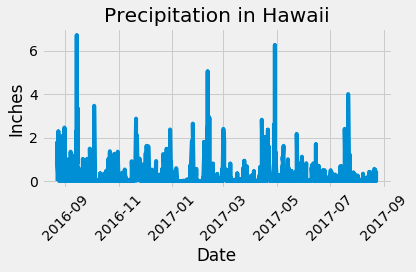

In [46]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(prcp_df["Date"], prcp_df["Precipitation"])
plt.title("Precipitation in Hawaii")
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation='45')
plt.tight_layout()
plt.show()

In [47]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

- Design a query to calculate the total number of stations.
- Design a query to find the most active stations.
- List the stations and observation counts in descending order.
- Which station has the highest number of observations?
- Hint: You may need to use functions such as func.min, func.max, func.avg, and func.count in your queries.
- Design a query to retrieve the last 12 months of temperature observation data (TOBS).
- Filter by the station with the highest number of observations.
- Plot the results as a histogram with bins=12.

In [48]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(func.count(Station.station)).all()[0][0]
print(f"THere are {num_stations} stations.")

THere are 9 stations.


In [53]:
# What are the most active stations? (i.e. what stations have the most rows)?
obser_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
# List the stations and the counts in descending order.
obser_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [54]:
station_id = obser_stations[0][0]
station_name = session.query(Station.name).filter(Station.station == station_id).all()[0][0]

print(f"{station_name} has the highest number of observations")

WAIHEE 837.5, HI US has the highest number of observations


In [56]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
tobs_query = session.query(Measurement.tobs, Measurement.station).\
filter(Measurement.date >= last_year, Measurement.date <= last_date).\
order_by(Measurement.date).statement

In [58]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_query2 = session.query(Measurement.tobs, Measurement.station).\
filter(Measurement.date >= last_year, Measurement.date <=last_date).\
filter(Measurement.station == station_id).\
order_by(Measurement.date).statement

tobs_df = pd.read_sql(tobs_query2, engine).dropna()
tobs_df

,tobs,station
0,77.0,USC00519281
1,77.0,USC00519281
2,80.0,USC00519281
3,80.0,USC00519281
4,75.0,USC00519281
...,...,...
347,77.0,USC00519281
348,77.0,USC00519281
349,76.0,USC00519281
350,76.0,USC00519281


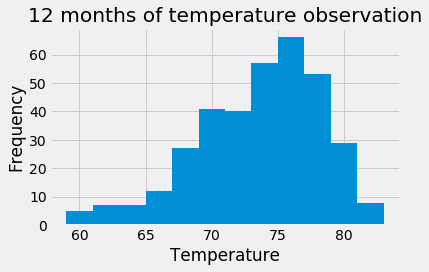

In [59]:
plt.hist(tobs_df["tobs"], bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("12 months of temperature observation")
plt.tight_layout()
plt.show()

# Bonus Challenge Assignment

In [60]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [67]:
start_date = '2012-02-28'
end_date = '2012-03-05'

In [68]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tmin, tavg, tmax = calc_temps(start_date, end_date)[0], calc_temps(start_date, end_date)[1], calc_temps(start_date, end_date)[2]

IndexError: list index out of range

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

NameError: name 'Measurement' is not defined

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [24]:
# Plot the daily normals as an area plot with `stacked=False`